In [1]:
%reload_ext autoreload
%autoreload 2

In [36]:
import sys; sys.path.append('scripts')
from common import *
from global_common import *
from models import *

In [40]:
# Читаем данные--------------------------------------
path_to_data = Path('../data')
train_df = pd.read_csv(path_to_data/'train_music.csv')
# train_y = train_df['target']
# del train_df['target']

test_df  = pd.read_csv(path_to_data/'test_music.csv')

sample_submission_df = pd.read_csv(path_to_data/'sample_submission_music.csv')
print(f'Shape of train {train_df.shape}\nShape of test {test_df.shape}\n')

# Объединяем выборки для обработки переменных, запоминаем индексы чтобы потом разделить назад
# train_idx = train_df.index[-1]
# merged = pd.concat([train_df, test_df], axis=0, )
# Raw data
test_df['Target'] = np.nan

merged = train_df.append(test_df, sort = True)

# целочисленные переменные----------------------
int_columns = [o for o in train_df.columns for crit in ['flag', 'is', 'count'] if crit in o]
int_columns += ['sim_count', 'device_type', 'manufacturer_category', 'os_category', 'tp_flag', 
                'days_exp', 'paym_last_days']
print(f'Целочисленных переменных  : {len(int_columns)}')

# Если в значениях переменной есть 0, тогда пропуски заполняет -1. Если нет 0, тогда заполняем нулем.
merged[int_columns] = merged[int_columns].apply(lambda x: x.fillna(-1) if 0 in x.values else x.fillna(0))
merged[int_columns] = merged[int_columns].apply(lambda x: x.astype('int'))
print('Целочисленные переменные обработаны.')

# с плавающей точкой переменные----------------------
float_cols = [o for o in train_df.columns for crit in ['data_type', 'rr', 'vol', 'cost', 'dur', 
                                                       'sum', 'part', 'clc', 'lt', 'brnd'] if crit in o]
print(f'Переменных с плавающей точкой : {len(float_cols)}')

merged[float_cols] = merged[float_cols].apply(lambda x: x.fillna(x.median()) if 0 in x.values else x.fillna(0))
merged[float_cols] = merged[float_cols].apply(lambda x: x.astype('float'))
print('Переменных с плавающей точкой обработаны.')

Shape of train (70000, 461)
Shape of test (30000, 460)

Целочисленных переменных  : 236
Целочисленные переменные обработаны.
Переменных с плавающей точкой : 225
Переменных с плавающей точкой обработаны.


In [31]:
# # Разделяем обработанные обучающую и тестовую выборки
# train = merged.iloc[:train_idx+1, :]
# train['target'] = train_y
# test = merged.iloc[train_idx+1:, :]
# del merged
# del train_y

In [35]:
import featuretools as ft

In [ ]:
train_valid = train.loc[train['parentesco1'] == 1, ['idhogar', 'Id', 'Target']].copy()
test_valid = test.loc[test['parentesco1'] == 1, ['idhogar', 'Id']].copy()

submission_base = test[['Id', 'idhogar']]

In [41]:
data = merged

# Remove Correlated Features

In [42]:
# Create correlation matrix
corr_matrix = data.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.975)]

print(f'There are {len(to_drop)} correlated columns to remove.')
print(to_drop)

There are 28 correlated columns to remove.
['count_act_type_5', 'count_act_type_7', 'count_gift_type_2', 'paym_sum_m1', 'paym_sum_m2', 'rr_gift_type_2', 'service_2_flag', 'sms_roam_in_count_m1', 'sms_roam_in_count_m2', 'sms_roam_in_count_m3', 'voice_omo_cc_count_m2', 'voice_omo_cc_count_m3', 'voice_onnet_cc_count_m1', 'voice_onnet_cc_count_m2', 'voice_onnet_cc_count_m3', 'voice_onnet_in_count_m1', 'voice_onnet_in_count_m2', 'voice_onnet_in_count_m3', 'voice_onnet_in_dur_m1', 'voice_onnet_in_dur_m2', 'voice_onnet_in_dur_m3', 'voice_onnet_out_count_m1', 'voice_onnet_out_count_m2', 'voice_onnet_out_count_m3', 'voice_onnet_out_dur_m1', 'voice_onnet_out_dur_m2', 'voice_onnet_out_dur_m3', 'voice_pstn_out_dur_m1']


In [45]:
data = data.drop(columns = to_drop)

In [46]:
import featuretools.variable_types as vtypes

In [75]:
vars_bool = list(set([o for o in data.columns for crit in ['flag', 'is'] if crit in o] ))            
vars_int = [o for o in train_df.columns for crit in ['count'] if crit in o] + ['sim_count', 'days_exp', 'paym_last_days']
vars_cont = float_cols

In [76]:
len(vars_cont) + len(vars_bool) + len(vars_int)

456

In [84]:
data[vars_bool] = data[vars_bool].apply(lambda x: x.astype('bool'))

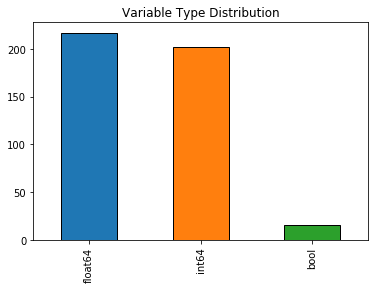

In [85]:
data.dtypes.value_counts().plot.bar(edgecolor = 'k');
plt.title('Variable Type Distribution');

In [87]:
es = ft.EntitySet(id = 'dataset')
es.entity_from_dataframe(entity_id = 'data', 
                         dataframe = data, 
                         index = 'id')

Entityset: dataset
  Entities:
    data [Rows: 100000, Columns: 434]
  Relationships:
    No relationships

In [17]:
def show_feature_stats(train_df, test_df, feat_train, feat_test, feature_name):
    '''
    Inputs:
    =======
    feat_train, feat_test : vectors with shape (len, );
    feature_name : string
    '''
    
    # Здесь мы добавляем наши новые признаки
    train_df[f"{feature_name}"] = feat_train.reshape(-1, 1)
    test_df[f"{feature_name}"] = feat_test.reshape(-1, 1)
    
    fig, ax = plt.subplots(1,2, figsize=(14, 6))
    
    # Здесь мы смотрим распределение переменной в обуч. и тестовой выборках
    sns.distplot(feat_train, kde=False, label='Train', ax=ax[0]);
    sns.distplot(feat_test, kde=False, label='Test', ax=ax[0]);
    ax[0].set_yscale('log')
    ax[0].set_title(f'{feature_name} Distr Train / Test')
    ax[0].legend();
    ax[0].set_xlabel(f'{feature_name}')
    fig.tight_layout()
    
    # Здесь мы смотрим распределение переменной для целевых значений и остальных
    sns.distplot(train_df[train_df['target'] == 1][f"{feature_name}"], label='Alice', kde=False)
    sns.distplot(train_df[train_df['target'] == 0][f"{feature_name}"], label='Other', kde=False)
    ax[1].set_yscale('log')
    ax[1].set_title(f'{feature_name} Distr Train / Test')
    ax[1].legend();
    ax[1].set_xlabel(f'{feature_name}')
    
    fig.tight_layout()

In [24]:
def show_feature(train_df, test_df, feature_name):
    '''
    Inputs:
    =======
    feat_train, feat_test : vectors with shape (len, );
    feature_name : string
    '''
    
    print(np.corrcoef(train_df[f"{feature_name}"].values, 
                      train_df['target'].values))
    
    fig, ax = plt.subplots(1,2, figsize=(14, 6))
    
    # Здесь мы смотрим распределение переменной в обуч. и тестовой выборках
    sns.distplot(train_df[f"{feature_name}"], kde=False, label='Train', ax=ax[0]);
    sns.distplot(test_df[f"{feature_name}"], kde=False, label='Test', ax=ax[0]);
    ax[0].set_yscale('log')
    ax[0].set_title(f'{feature_name} Distr Train / Test')
    ax[0].legend();
    ax[0].set_xlabel(f'{feature_name}')
    fig.tight_layout()
    
    # Здесь мы смотрим распределение переменной для целевых значений и остальных
    sns.distplot(train_df[train_df['target'] == 1][f"{feature_name}"], label='Alice', kde=False)
    sns.distplot(train_df[train_df['target'] == 0][f"{feature_name}"], label='Other', kde=False)
    ax[1].set_yscale('log')
    ax[1].set_title(f'{feature_name} Distr Train')
    ax[1].legend();
    ax[1].set_xlabel(f'{feature_name}')
    
    fig.tight_layout()

[[1.       0.126873]
 [0.126873 1.      ]]


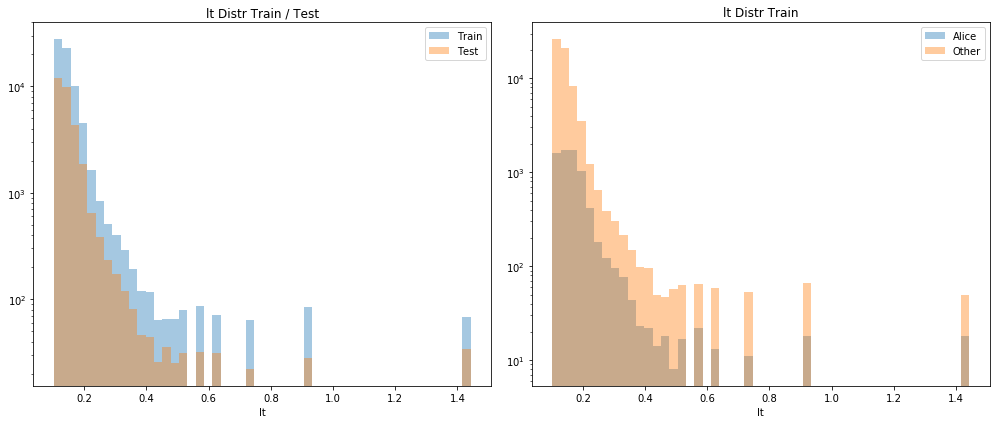

In [25]:
show_feature(train, test, 'lt')

[[1.      0.01998]
 [0.01998 1.     ]]


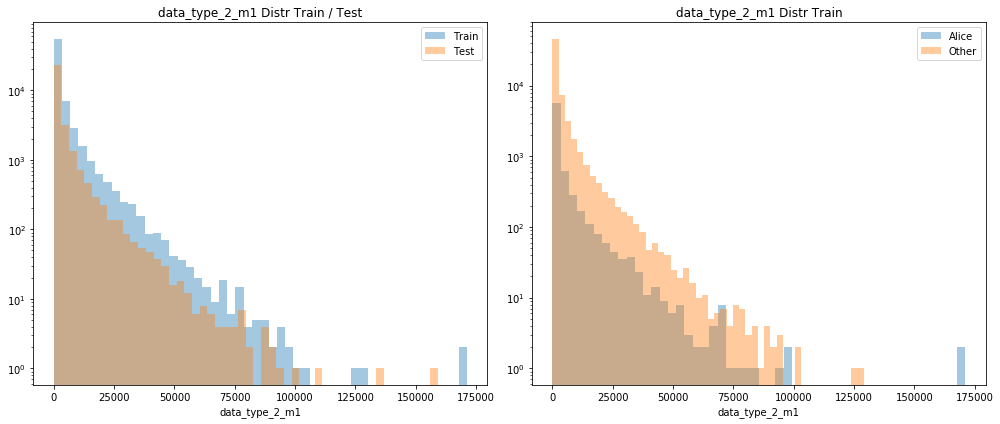

In [27]:
show_feature(train, test, 'data_type_2_m1')

[[1.       0.009482]
 [0.009482 1.      ]]


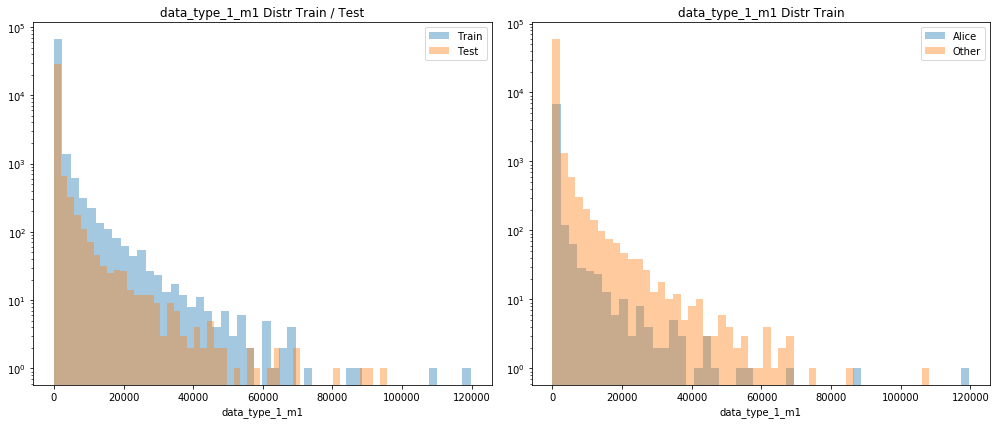

In [28]:
show_feature(train, test, 'data_type_1_m1')

[[1.       0.003612]
 [0.003612 1.      ]]


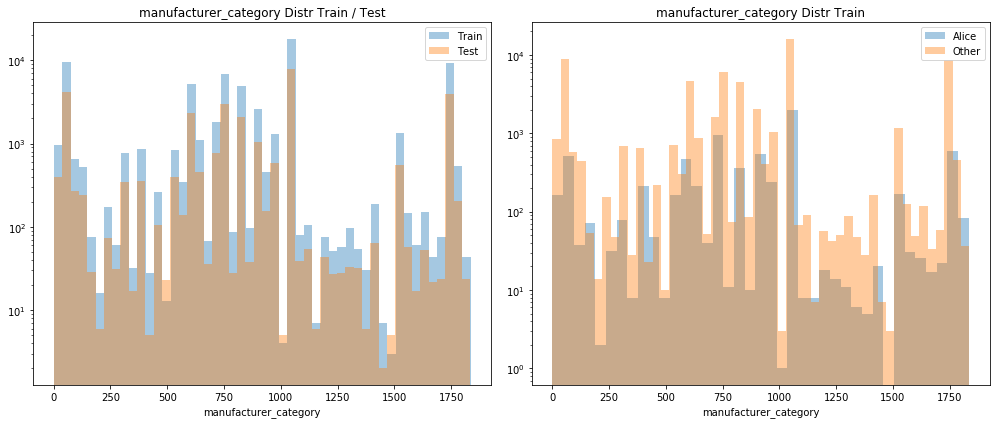

In [29]:
show_feature(train, test, 'manufacturer_category')